In [42]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, ZeroPadding2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, activations
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

In [11]:
# from zipfile import ZipFile

# with ZipFile('archive.zip', 'r') as zipObj:
#    # Extract all the contents of zip file in current directory
#    zipObj.extractall()
img_size = 100

datadir = "dataset"

#datadir = r'C:\Users\pc\source\repos\CvprAssignment\Final\Dataset'
CATEGORIES = os.listdir(datadir)
print(CATEGORIES)

['Form-based Marking.xlsx', 'Readme.txt', 'test', 'train']


In [19]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator


TRAINING_DIR = r'C:\Users\pc\Desktop\thesis code\dataset\train'


In [20]:
from keras_preprocessing.image import ImageDataGenerator

# Define your batch size
batch_size = 32

# Reduce image dimensions
target_size = (64, 64)

# Decrease augmentation operations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=False,
    validation_split=0.28
)

# Flow data from the directory with reduced parameters
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=target_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=target_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation'
)


Found 116760 images belonging to 84 classes.
Found 45360 images belonging to 84 classes.


In [67]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, concatenate, UpSampling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout

class UnetVgg19():

    def make_unet_segmentation_branch(self, input_layer):
        # U-Net segmentation branch
        conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
        conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
        conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
        conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
        conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
        drop4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

        conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
        conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
        drop5 = Dropout(0.5)(conv5)

        up6 = Conv2D(512, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
        merge6 = concatenate([drop4, up6], axis=3)
        conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
        conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

        up7 = Conv2D(256, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
        merge7 = concatenate([conv3, up7], axis=3)
        conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
        conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

        up8 = Conv2D(128, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
        merge8 = concatenate([conv2, up8], axis=3)
        conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
        conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

        up9 = Conv2D(64, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
        merge9 = concatenate([conv1, up9], axis=3)
        conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
        conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

        segmentation_output = Conv2D(self.num_classes, (1, 1), activation='softmax')(conv9)
        return segmentation_output

    def make_classification_branch(self, input_layer):
        # VGG19 classification branch
        vgg_base = VGG19(weights='imagenet', include_top=False, input_tensor=input_layer)

        flatten_layer = Flatten()(vgg_base.layers[-1].output)
        dense1 = Dense(4096, activation='relu')(flatten_layer)
        dense2 = Dense(4096, activation='relu')(dense1)

        classification_output = Dense(self.num_classes, activation='softmax')(dense2)
        return classification_output

    def make_model(self, input_shape, num_classes):
        self.num_classes = num_classes

        input_layer = Input(shape=input_shape)

        # U-Net segmentation branch
        segmentation_output = self.make_unet_segmentation_branch(input_layer)

        # VGG19 classification branch
        classification_output = self.make_classification_branch(input_layer)

        model = Model(inputs=input_layer, outputs=[segmentation_output, classification_output])
        return model

    def show_summary(self, model):
        model.summary()

    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes


# Usage example:
input_shape = (256, 256, 3)
num_classes = 2  # Adjust this to the number of classes 

unet_vgg = UnetVgg19(input_shape, num_classes)
model = unet_vgg.make_model(input_shape, num_classes)
unet_vgg.show_summary(model)


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_61 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_269 (Conv2D)         (None, 256, 256, 64)         1792      ['input_61[0][0]']            
                                                                                                  
 conv2d_270 (Conv2D)         (None, 256, 256, 64)         36928     ['conv2d_269[0][0]']          
                                                                                                  
 max_pooling2d_65 (MaxPooli  (None, 128, 128, 64)         0         ['conv2d_270[0][0]']          
 ng2D)                                                                                     

Epoch 1/50
3649/3649 [==============================] - ETA: 0s - loss: 1.3885 - accuracy: 0.6314
Epoch 1: val_loss improved from inf to 0.35883, saving model to best_model.h5


C:\Users\pc\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3649/3649 [==============================] - 2799s 767ms/step - loss: 1.3885 - accuracy: 0.6314 - val_loss: 0.3588 - val_accuracy: 0.8986 - lr: 0.0010
Epoch 2/50
3649/3649 [==============================] - ETA: 0s - loss: 0.7671 - accuracy: 0.7846
Epoch 2: val_loss improved from 0.35883 to 0.30404, saving model to best_model.h5
3649/3649 [==============================] - 2744s 752ms/step - loss: 0.7671 - accuracy: 0.7846 - val_loss: 0.3040 - val_accuracy: 0.9126 - lr: 0.0010
Epoch 3/50
3649/3649 [==============================] - ETA: 0s - loss: 0.6215 - accuracy: 0.8222
Epoch 3: val_loss improved from 0.30404 to 0.25151, saving model to best_model.h5
3649/3649 [==============================] - 2649s 726ms/step - loss: 0.6215 - accuracy: 0.8222 - val_loss: 0.2515 - val_accuracy: 0.9296 - lr: 0.0010
Epoch 4/50
3649/3649 [==============================] - ETA: 0s - loss: 0.5312 - accuracy: 0.8447
Epoch 4: val_loss improved from 0.25151 to 0.23639, saving model to best_model.h5
3649/36

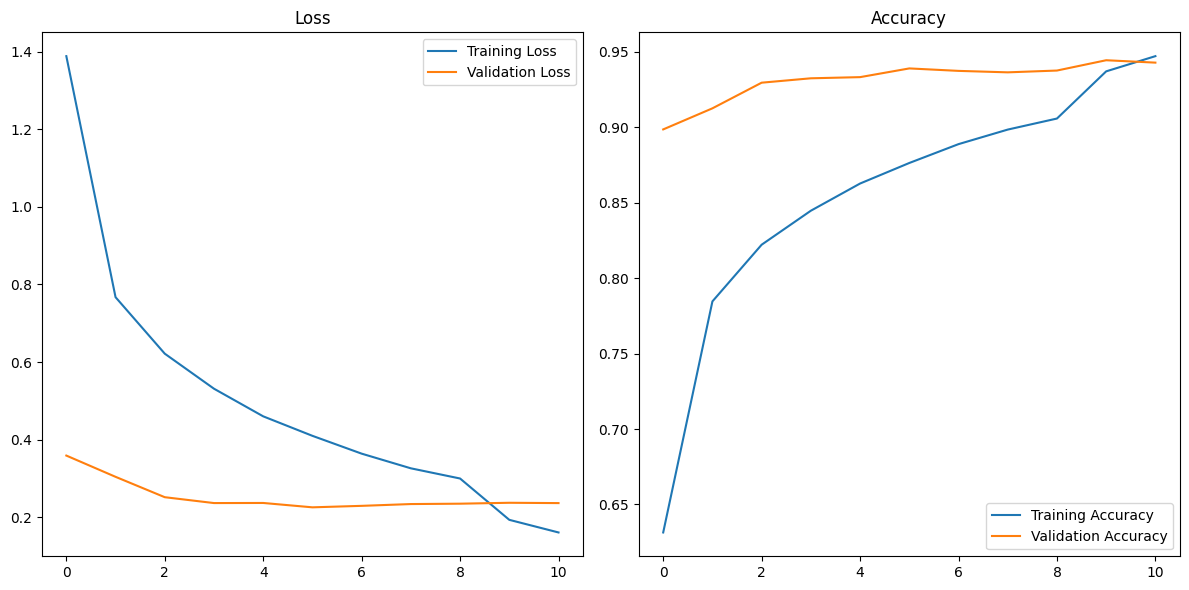

In [70]:
# Define the number of classes in your dataset
num_classes = 84  

# Define the output layer with the correct number of units
model = keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  
])

# Compile the model as before
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
epochs = 50  # You can adjust this as needed
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(validation_generator, verbose=2)
print("\nTest accuracy:", test_acc)

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.tight_layout()
plt.show()
